# Train 3D network on Memento

In [1]:
# Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from cv2 import imread, resize
from scipy.stats import spearmanr
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Input, TimeDistributed
from keras.models import Model
from keras.utils import Sequence
import keras.backend as K
from keras.optimizers import Adam, SGD
from timeit import default_timer as timer
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
import pickle
import json
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sys.path.append('../src/')
sys.path.append('../imgaug')
from generator import VideoSeqGenerator, preprocess_i3d_rgb
from vid_utils import load_video_opencv, plot_frames
from keras_training import MultiGPUCheckpoint
from memento_utils import *
from imgaug import augmenters as iaa
from imgaug import parameters as iap

import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2


Using TensorFlow backend.
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
print("keras version:", keras.__version__)
print("tf version:", tf.__version__)

keras version: 2.3.1
tf version: 1.14.0


In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# print(os.environ['CUDA_VISIBLE_DEVICES'])

In [4]:
%%bash
nvidia-smi

Tue Oct  6 19:21:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:1A:00.0 Off |                  N/A |
| 41%   32C    P8    24W / 280W |     11MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           On   | 00000000:68:00.0 Off |                  N/A |
| 41%   

# Key vars

In [5]:
data_type = 'rgb'
dataset = 'memento10k'
gpus = 1
resc = 1
use_sw = 1
bs = 8
do = 0.3
loss_type = 'alphamse'

# Fetch video names, alphas and memorability scores


In [6]:
if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if data_type=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../memento10k_labels/'
    names_with_slash = False
    load_func = 'npy_'+data_type
else:
    data_path = '../../memento'
    labels_path = '../../memento_data'
    names_with_slash = True
    load_func = 'vids_opencv'



# Fetch scores from ground truth json file with a defined T
T = 80
mem_scores_file = 'normalized_mem_scores_ma_T=%d.json' % T
alpha_file = 'alphas_ma_T=%d.json' % T

   


name_to_mem_alpha, name_to_mem, name_to_alpha =  get_name_to_mem_dict(mem_scores_file, 
                                                                 alpha_file, 
                                                                 labels_path, 
                                                                 names_with_slash=names_with_slash)

# print(name_to_mem_alpha)

train_names, val_names = get_train_test_sets(os.path.join(labels_path, 'memento_train_val_test.json'), 
                                             names_with_slash=names_with_slash)

print('Loaded %d train videos and %d val videos\n' % (len(train_names), len(val_names)))


# Check if all names are in dict
for tn in train_names:
    if tn not in name_to_mem_alpha.keys():
        print('Train vid not in dict:',tn)
        
for tn in val_names:
    if tn not in name_to_mem_alpha.keys():
        print('Val vid not in dict:',tn)


FileNotFoundError: [Errno 2] No such file or directory: '../../memento_data/normalized_mem_scores_ma_T=80.json'

## Get weights if needed

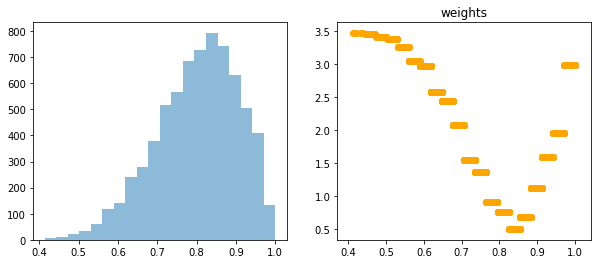

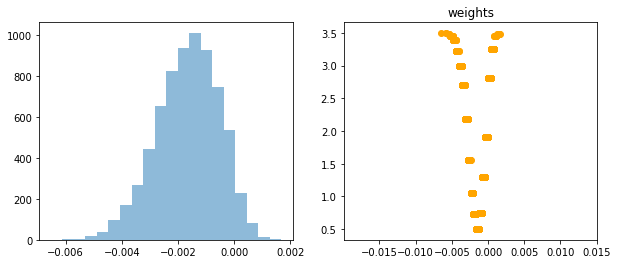

In [7]:
if use_sw:
    factor = 3
    mem_weights = get_sample_weights([name_to_mem_alpha[n][0] for n in train_names], factor=factor)
    alpha_weights = get_sample_weights([name_to_mem_alpha[n][1] for n in train_names], factor=factor)
    
    sw=np.array(mem_weights)
else:
    sw=None

In [8]:
print([name_to_mem_alpha[n][0] for n in train_names][:10])
print(mem_weights[:10])

[0.5987934615362276, 0.9271166725316646, 0.8065429419146252, 0.6770216315408998, 0.8592952213725819, 0.7359736408166242, 0.7535337425529223, 0.9032796264301027, 0.7089505472648836, 0.8352799746575212]
[2.97103275 1.59571788 0.75692695 2.43828715 0.68891688 1.54282116
 1.36523929 1.11964736 1.54282116 0.5       ]


# Generator

In [9]:
# Instantiating generator
gen_train = VideoSeqGenerator(files=np.array(train_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv= None, 
                            augment= None, #['dropout', 'cutout'],
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=True,
                            is_train=True,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha,
                            sample_weights=sw)

gen_val = VideoSeqGenerator(files=np.array(val_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha,
                            sample_weights=sw)

Caution: batch_size (8) is not multiple of given dataset length (7004). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 7004 . Augmentation:  None
Caution: batch_size (8) is not multiple of given dataset length (1506). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 1506 . Augmentation:  None


# Test Generator


Total time on this batch: 0.8485962679842487  - it: 0 - idx: 222
Time loading: 0.712815857026726
Time preprocessing: 0.13268549996428192
Time augmenting: 0.0030949109932407737
mem, alpha, np.max(b), np.min(b) 0.8002027133030506 -0.002441832607373027 255.0 0.0


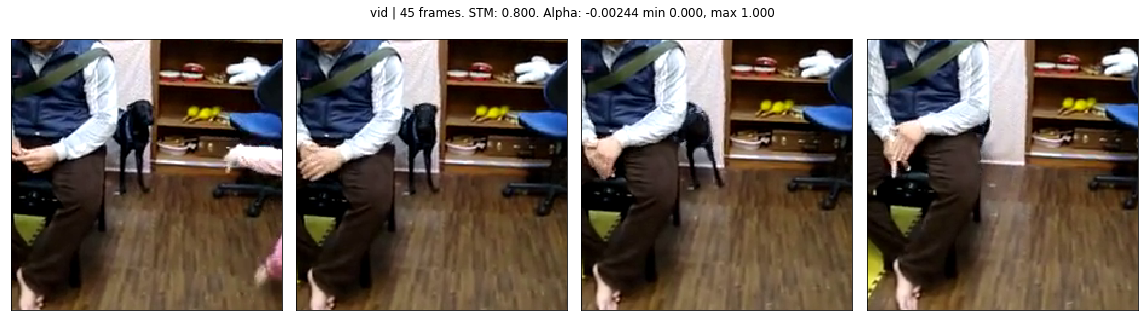

mem, alpha, np.max(b), np.min(b) 0.7653628885847554 -0.00192337234309974 255.0 0.0


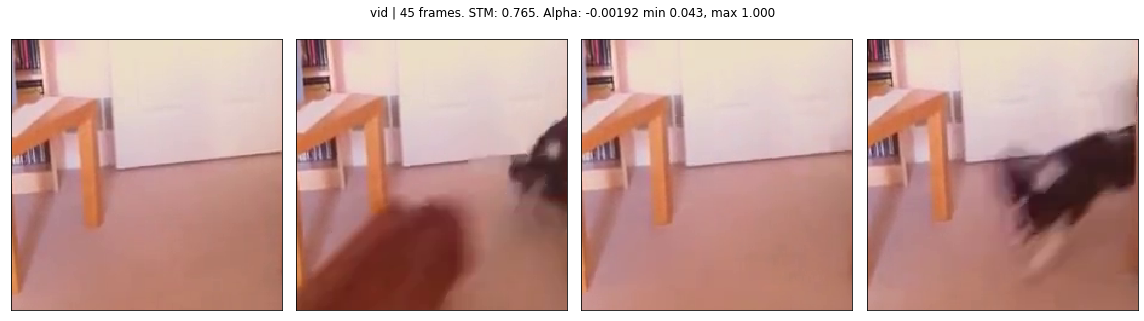

mem, alpha, np.max(b), np.min(b) 0.8506419743419446 -0.0030745031149264175 255.0 0.0


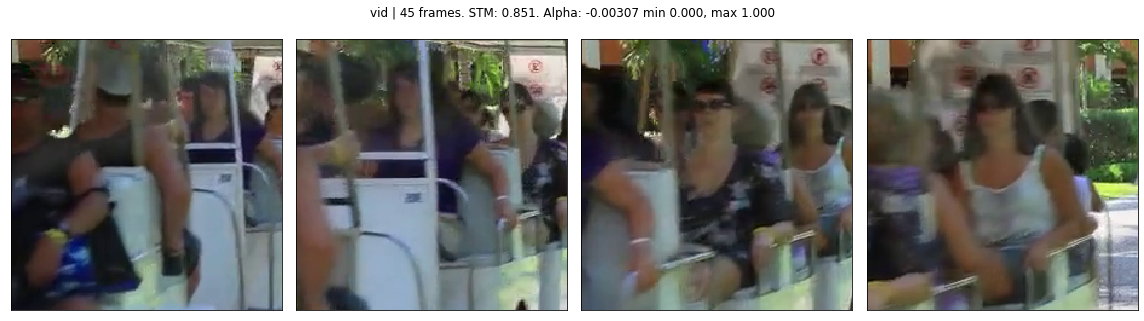

mem, alpha, np.max(b), np.min(b) 0.753806966952523 -0.002314308445190281 255.0 0.0


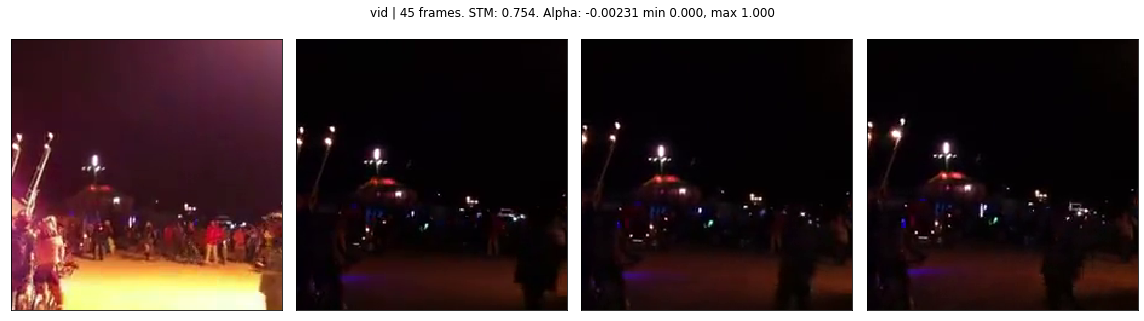

mem, alpha, np.max(b), np.min(b) 0.711708184550682 -0.0025220989880425397 255.0 0.0


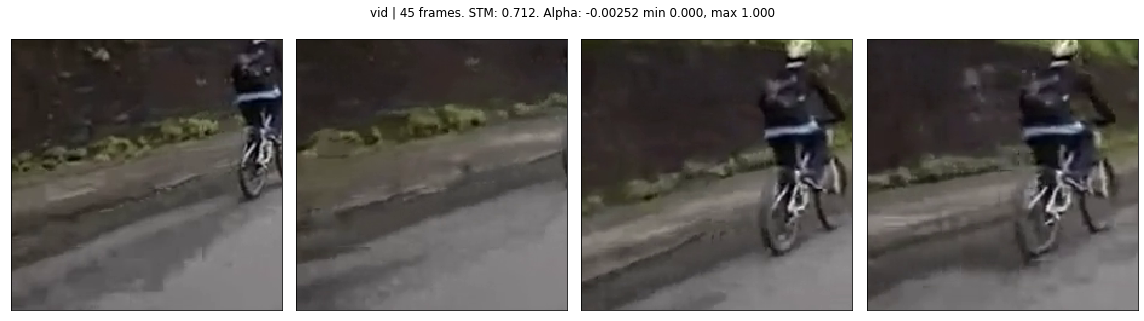

mem, alpha, np.max(b), np.min(b) 0.8676825392589502 -0.0014498458268942917 255.0 0.0


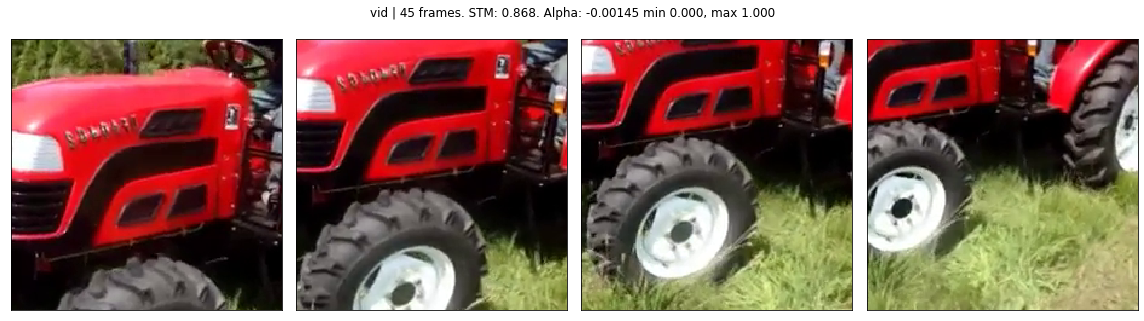

mem, alpha, np.max(b), np.min(b) 0.9014278587013087 0.00029063244484548156 255.0 0.0


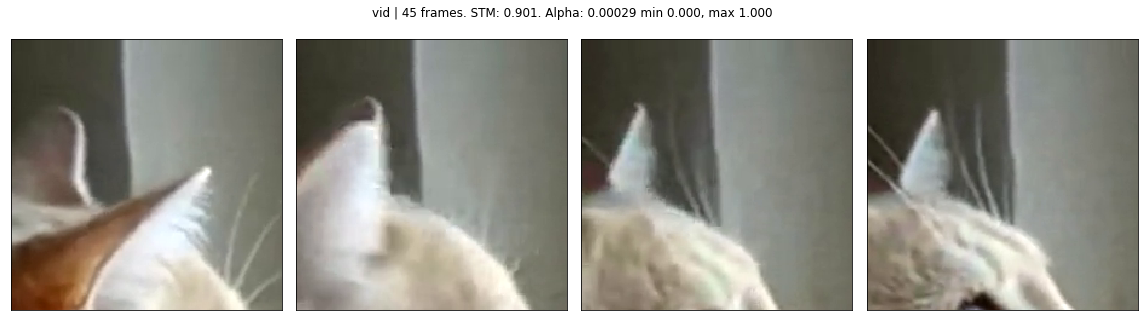

mem, alpha, np.max(b), np.min(b) 0.6604141058425991 -0.0014673474021272513 253.0 19.0


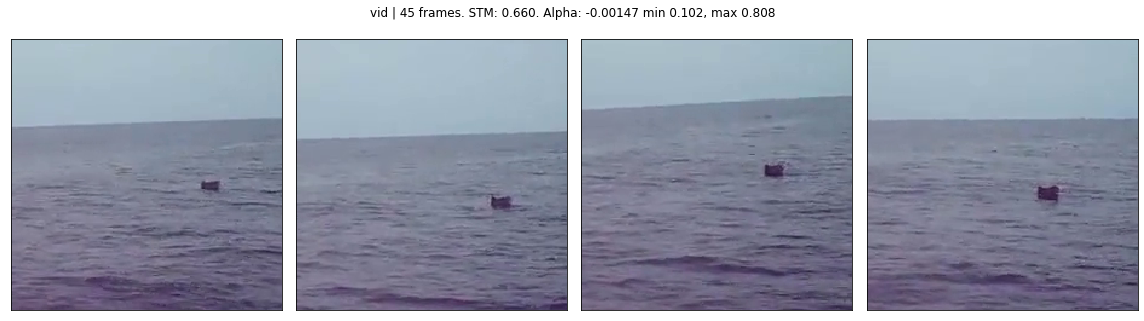

In [10]:
# Choose N videos from memento training

ret = gen_train.__getitem__(np.random.randint(len(gen_train)))

batch=ret[0]
labels=ret[1]


# Display
for i,b in enumerate(batch):
    
    mem, alpha = labels[i]
    
    print('mem, alpha, np.max(b), np.min(b)',mem, alpha, np.max(b), np.min(b))
    
    plot_frames(b, 
                title='%s | %d frames. STM: %.3f. Alpha: %.5f' % ('vid',len(b),mem,alpha),
                is_optical_flow=True if data_type=='flow' else False,
                suptitle_y=0.89,
                is_255image=True, 
                frames_to_show=4)

In [11]:
# import pandas as pd

# df = pd.read_csv("../../memento_data/memento_captions_three_rounds_clean_final.csv", index_col=0)

# display(df)


# tot_unw_cap = 0
# for c in df.columns:
#     if 'caption' in c:
#         tot_unw_cap += len(df[df[c].str.contains('\?|!|"..."')])

# print("Total captions with unwanted punctuation (!, ?, ...): %d" % tot_unw_cap)

# Model

In [16]:
# Fetching pretrained i3d

i3d = build_model_multigpu(type=data_type, 
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=2,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=do, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=resc)
    
    


Working with single GPU
x.shape after downsa: (None, 23, 28, 28, 192)
channels_last
x.shape after last conv: (None, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /home/camilo/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
x.shape before last conv (None, 5, 1, 1, 1024)
x.shape after last conv (None, 5, 1, 1, 2)
Model: "i3d_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i3d_input (InputLayer)       (None, 45, 224, 224, 3)   0         
_________________________________________________________________
rescale_lambda (Lambda)      (None, 45, 224, 224, 3)   0         
_________________________________________________________________
i3d_inception (Model)        multiple                  12294544  
_________________________________________________________________
Conv3d_6a_1x1_conv (Conv3D)  (None, 5, 1, 1, 2)        2050      
______________________

In [13]:
%%bash
cd ../ckpt/i3d
ls

memento10k_flow_ep02_valloss8.4081.hdf5
memento10k_flow_ep03_valloss8.4215.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep18_valloss0.0318_valrc0.3915.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep24_valloss0.0318_valrc0.3913.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss6.5899_valrc0.5125.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss7.1522_valrc0.4311.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss7.5053_valrc0.5007.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.4512_valrc0.5129.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.5719_valrc0.5168.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.5733_valrc0.4976.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep03_valloss6.4578_valrc0.

In [17]:
# Load weights
W = '../ckpt/i3d/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep07_valloss6.8248_valrc0.5935.hdf5' #None #'../ckpt/i3d/memento10k_flow_ep06_valloss8.8485.hdf5'
if W:
    i3d.load_weights(W)

In [18]:
i3d.save(W[:-5]+'_full_model.hdf5')

KeyError: 'lambda_4_ib-0'

In [ ]:
# TESTING LOSS
# loss = loss_alpha_mse(print_=True)

# for i in range(5):
#     ret = gen_train.__getitem__(i)
#     batch = ret[0]
#     labels = ret[1]
#     preds = i3d.predict(batch)
#     loss(K.variable(labels), K.variable(preds))

# Train last layers

In [ ]:
print('TRAINING WITH %d GPUS'%gpus)

i3d = freeze_unfreeze_net(i3d, gpus, freeze=True)
i3d.summary()

# Define optimizer
lr=0.00001
optimizer = Adam(lr=lr)

print('Compiling model')

# Compile model
a=1
b=100
c=10
i3d.compile(optimizer=optimizer,
              loss=loss_alpha_mse(a,b,c) if loss_type=='alphamse' else loss_alpha,
              metrics=['mse'])
    

ckpt_filepath = get_ckpt_name('../ckpt/i3d', dataset, data_type, True, resc, gpus, bs, loss_type, use_sw, do, a,b,c)
cbs =define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=3)



print('Ready to train last layer')
print('ckpt_filepath:',ckpt_filepath)
# Training
i3d.fit_generator(gen_train, 
                  epochs=20,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=30,
                  validation_data=gen_val, 
                  workers=10)


# Train full network

In [ ]:
print('TRAINING WITH %d GPUS'%gpus)

i3d = freeze_unfreeze_net(i3d, gpus, freeze=False)
i3d.summary()

        
lr=0.001
optimizer = Adam(lr=lr)

a=1
b=100
c=10
i3d.compile(optimizer=optimizer,
              loss=loss_alpha_mse(a,b,c) if loss_type=='alphamse' else loss_alpha,
              metrics=['mse'])

i3d.summary()

ckpt_filepath = get_ckpt_name('../ckpt/i3d', dataset, data_type, False, resc, gpus, bs, loss_type, use_sw, do,a,b,c)
cbs =define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=1)

    
print('Ready to train full net')

# Training
i3d.fit_generator(gen_train, 
                  epochs=25,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=30,
                  validation_data=gen_val, 
                  workers=10)


# Predict and Evaluate RC

In [ ]:
# Load model if necessary
W = '../ckpt/i3d/memento10k_flow_ep10_valloss11.7493.hdf5'

# i3d.load_weights(W)

In [ ]:
# Predict
preds = i3d.predict_generator(gen_val, verbose=1)

In [ ]:
    pred_mem = [p[0] for p in preds]
    pred_alpha = [p[1] for p in preds]

    true_mem=[]
    true_alpha=[]

    verbose=False

    for i,n in enumerate(val_names[:-3]):
        if verbose:
            print('Name:',n)
            print('True mem:',name_to_mem_alpha[n][0])
            print('Pred mem:',pred_mem[i])
            print('True alpha:',name_to_mem_alpha[n][1])
            print('Pred alpha:',pred_alpha[i])
        true_mem.append(name_to_mem_alpha[n][0])
        true_alpha.append(name_to_mem_alpha[n][1])

    print('First 8 gt mem:', true_mem[:8])
    print('First 8 pred mem:', pred_mem[:8])

    # assert(len(preds)==len(val_names))

    rc = spearmanr(pred_mem, true_mem)
    alpha_rc = spearmanr(pred_alpha, true_alpha)
    

    print('RC:', rc[0])
    print('Alpha_rc:',alpha_rc[0])